In [1]:
#https://www.kaggle.com/datasets/tariqsays/chatgpt-twitter-dataset?resource=download

In [42]:
# Imports
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import IDF, HashingTF, Tokenizer
from pyspark.sql.functions import col,udf,count
from pyspark.sql.types import FloatType
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from pyspark.ml.classification import NaiveBayes, LogisticRegression,DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import findspark

In [3]:
findspark.init()

### Carregando dados

In [4]:
# Criando o Spark Context
sc = SparkContext(appName = "Twitter")

In [5]:
# Spark Session - usada quando se trabalha com Dataframes no Spark
spark = SparkSession.builder.master("local").getOrCreate()


In [6]:
df_twitter =  spark.read.csv('chatgpt1.csv', header = True)

In [7]:
type(df_twitter)

pyspark.sql.dataframe.DataFrame

In [8]:
df_twitter.show(5)

+----------------------------------------+-------------------+---------------------------+--------+---------+----+--------+----------+----------+------------+---------+----------+--------------+--------+------+-----+-----------+--------------+-------+-------------+
|                                Datetime|           Tweet Id|                       Text|Username|Permalink|User|Outlinks|CountLinks|ReplyCount|RetweetCount|LikeCount|QuoteCount|ConversationId|Language|Source|Media|QuotedTweet|MentionedUsers|hashtag|hastag_counts|
+----------------------------------------+-------------------+---------------------------+--------+---------+----+--------+----------+----------+------------+---------+----------+--------------+--------+------+-----+-----------+--------------+-------+-------------+
|                    2023-01-22 13:44:...|1617156270871699456|ChatGPTで遊ぶの忘れてた！！|    null|     null|null|    null|      null|      null|        null|     null|      null|          null|    null|  null| n

### Tratando os dados

In [9]:
df_twitter.columns

['Datetime',
 'Tweet Id',
 'Text',
 'Username',
 'Permalink',
 'User',
 'Outlinks',
 'CountLinks',
 'ReplyCount',
 'RetweetCount',
 'LikeCount',
 'QuoteCount',
 'ConversationId',
 'Language',
 'Source',
 'Media',
 'QuotedTweet',
 'MentionedUsers',
 'hashtag',
 'hastag_counts']

In [10]:
#Selecionando somente as colunas para realização da análise de sentimento
df_twitter = df_twitter.select('Text', 'Language')

In [11]:
df_twitter.show()

+---------------------------+--------------------+
|                       Text|            Language|
+---------------------------+--------------------+
|ChatGPTで遊ぶの忘れてた！！|                null|
|                       null|                null|
|                       null|                null|
|                       null|                null|
|                       null|                null|
|       https://twitter.c...|                null|
|       @AlexandrovnaIng ...|                  en|
|       Schaut Euch an, w...|                null|
|                       null|                null|
|       https://twitter.c...|[Photo(previewUrl...|
|       Bow down to chatG...|                  en|
|       Profilinde vatan,...|                  tr|
|       ChatGPT’nin bilin...|                null|
|                       null|                null|
|       https://twitter.c...|                null|
|       ChatGPT runs 10K ...|                  en|
|       @SWENGDAD There i...|            

In [12]:
df_twitter.count()

82129

In [13]:
#Remover colunas sem twittes
df_twitter = df_twitter.dropna(subset= ['Text','Language'])

In [14]:
df_twitter.count()

39216

In [15]:
df_twitter.show()

+--------------------+--------------------+
|                Text|            Language|
+--------------------+--------------------+
|@AlexandrovnaIng ...|                  en|
|https://twitter.c...|[Photo(previewUrl...|
|Bow down to chatG...|                  en|
|Profilinde vatan,...|                  tr|
|ChatGPT runs 10K ...|                  en|
|@SWENGDAD There i...|                  en|
|https://twitter.c...|[Photo(previewUrl...|
|It will look simi...|                  en|
|https://twitter.c...|[Photo(previewUrl...|
|     PetrosTovmasyan|"<a href=""http:/...|
|J'ai juste demand...|                  fr|
|Google Presenta S...|                  es|
|@Slipcatch @nickh...|                  en|
|@paulgp Leverage ...|                  en|
|@FrankDeya The an...|                  en|
|esse chatGPT é bo...|                  pt|
|          chatgpt ☺️|                  en|
|ແຕ່ກີ້ຄົນຫາເງິນໄດ...|                  lo|
|#Tech: Google is ...|                  en|
|Problems of Pakis...|          

In [16]:
#Manter somente twittes em inglês
df_twitter= df_twitter.filter((col('Language')=='en'))

In [17]:
df_twitter.count()

21677

In [18]:
df_twitter = df_twitter.select('Text')
df_twitter.show()

+--------------------+
|                Text|
+--------------------+
|@AlexandrovnaIng ...|
|Bow down to chatG...|
|ChatGPT runs 10K ...|
|@SWENGDAD There i...|
|It will look simi...|
|@Slipcatch @nickh...|
|@paulgp Leverage ...|
|@FrankDeya The an...|
|          chatgpt ☺️|
|#Tech: Google is ...|
|Problems of Pakis...|
|"The question is ...|
| in search of an ...|
|"@SamsungIndia I ...|
|@paulg Already mo...|
|@RVCJ_FB Blame it...|
|ChatGPT will chan...|
|@AlanLevinovitz T...|
|Learn ChatGPT now...|
|@ShiLLin_ViLLian ...|
+--------------------+
only showing top 20 rows



### Criar a coluna para o sentimento positivo, negativo ou neutro

In [19]:
#Initializa o sentiment analyzer
nltk.downloader.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pniet\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [20]:
df_twitter.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Text                                                                                                                                                                                                                                                                                      |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|@AlexandrovnaIng Prohibition of ChatGPT has been added to the honor code of my daughter’s school                                                

In [21]:
# Cria a função UDF para aplicar a analise de sentimento nos rótulos
#2 positivo, 1 neutro, 0 negativo
def analyze_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    if compound_score >= 0.05:
        sentimento = 2.0
    elif compound_score <= -0.05:
        sentimento =0.0
    else:
        sentimento = 1.0
    return sentimento

In [22]:
# Utiliza a função
analyze_sentiment_udf = udf(analyze_sentiment, FloatType())
# Aplica a analise de sentimentos UDF para criar a nova coluna
df_twitter = df_twitter.withColumn("label", analyze_sentiment_udf("Text"))

In [23]:
df_twitter.show()

+--------------------+-----+
|                Text|label|
+--------------------+-----+
|@AlexandrovnaIng ...|  2.0|
|Bow down to chatG...|  1.0|
|ChatGPT runs 10K ...|  1.0|
|@SWENGDAD There i...|  0.0|
|It will look simi...|  2.0|
|@Slipcatch @nickh...|  0.0|
|@paulgp Leverage ...|  2.0|
|@FrankDeya The an...|  0.0|
|          chatgpt ☺️|  1.0|
|#Tech: Google is ...|  0.0|
|Problems of Pakis...|  0.0|
|"The question is ...|  0.0|
| in search of an ...|  2.0|
|"@SamsungIndia I ...|  2.0|
|@paulg Already mo...|  2.0|
|@RVCJ_FB Blame it...|  0.0|
|ChatGPT will chan...|  2.0|
|@AlanLevinovitz T...|  0.0|
|Learn ChatGPT now...|  0.0|
|@ShiLLin_ViLLian ...|  0.0|
+--------------------+-----+
only showing top 20 rows



### Visualizar a distribuição do label

In [24]:
df_visulaiza = df_twitter.toPandas()
df_visulaiza['label'] = np.where(df_visulaiza['label'] ==2, 'Positivo',  np.where(df_visulaiza['label'] ==0,"Negativo","Neutro"))

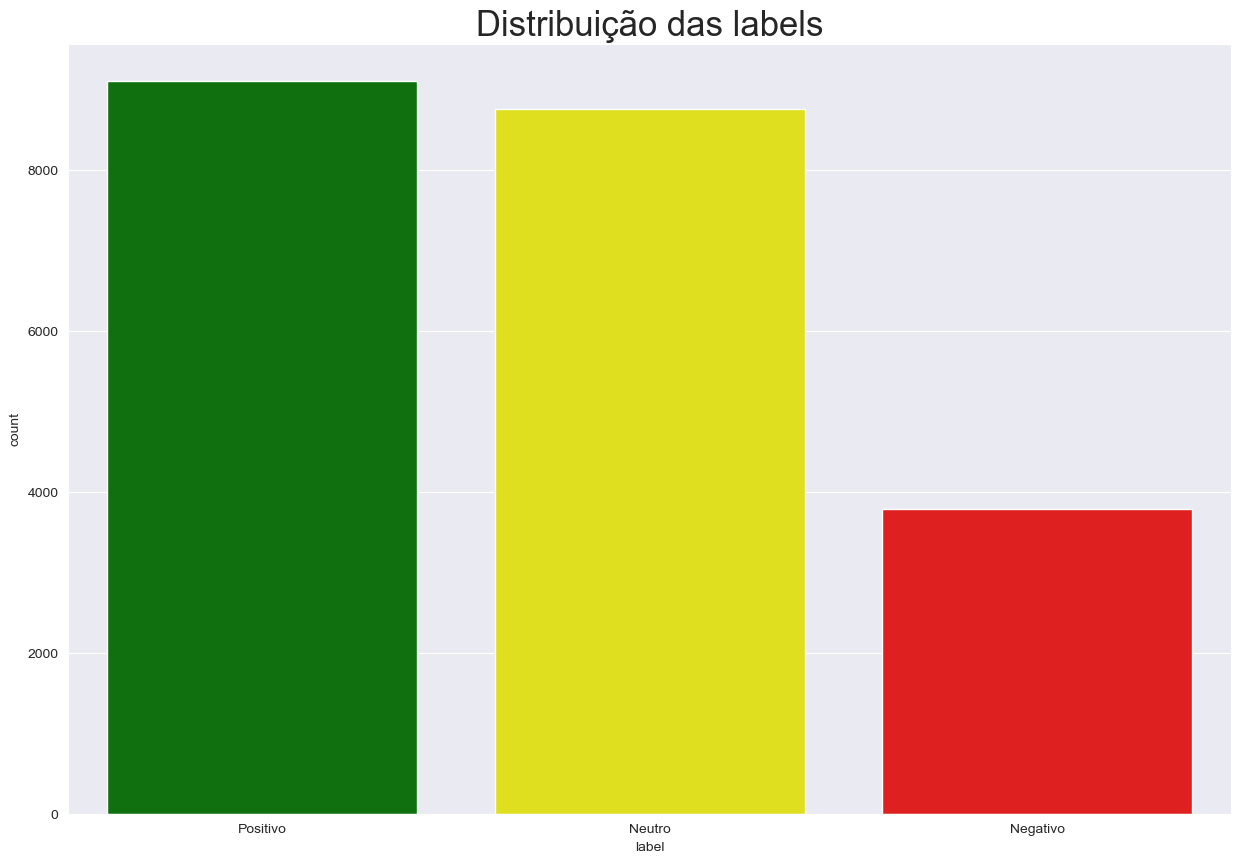

In [25]:
# Tamanho da figura
plt.figure(figsize=(15, 10))

# Chart
chart = sns.countplot(x='label',
                    data=df_visulaiza,
                      palette=['green', 'yellow', 'red'])
chart.set_title("Distribuição das labels", fontsize=25)


# Estilo e labels
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')


In [43]:
#listagem dos sentimentos por quantidade
df_twitter.groupby('label').agg(count(col("label")).alias('Total')).show()


+-----+-----+
|label|Total|
+-----+-----+
|  2.0| 9112|
|  1.0| 8770|
|  0.0| 3795|
+-----+-----+



### Processamento de Linguagem Natural

In [26]:
# Cria o Tokenizador
tokenizador = Tokenizer(inputCol='Text', outputCol='words')
type(tokenizador)

pyspark.ml.feature.Tokenizer

In [27]:
# Remove as stopwords
stopword_remover = StopWordsRemover(inputCol=tokenizador.getOutputCol(), outputCol='clean_words')
type(stopword_remover)

pyspark.ml.feature.StopWordsRemover

In [28]:
# Aplica o TF (Term Frequency) para extrair a frequência de cada termo nas linhas de texto
term_frequency = HashingTF(inputCol = stopword_remover.getOutputCol(), outputCol = "tempfeatures")
type(term_frequency)

pyspark.ml.feature.HashingTF

In [29]:
# Aplica o IDF (Inverse Document Frequency) para calcula a frequência inversa dos documentos
inverse_tf = IDF(inputCol = term_frequency.getOutputCol(), outputCol = "features")
type(inverse_tf)

pyspark.ml.feature.IDF

### Machine Learning

In [30]:
# Dados de Treino e de Teste
(dados_treino, dados_teste) = df_twitter.randomSplit([0.8, 0.2])

In [31]:
dados_treino.count()

17292

In [32]:
dados_teste.count()

4385

In [33]:
# Criação do modelo
nbClassifier = NaiveBayes()
logisticClassifier = LogisticRegression()

In [34]:
# Criação do Pipeline
pipeline = Pipeline(stages = [tokenizador,stopword_remover, term_frequency, inverse_tf,logisticClassifier])

In [35]:
# Treinamento do modelo com o Pipeline
modelo = pipeline.fit(dados_treino)

In [36]:
type(modelo)

pyspark.ml.pipeline.PipelineModel

In [37]:
# Previsões nos dados de teste
previsoes = modelo.transform(dados_teste)

In [38]:
previsoes.select("label", "prediction", "probability").show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       2.0|[2.52488912854667...|
|  1.0|       1.0|[1.66143328282945...|
|  2.0|       0.0|[0.99785595600720...|
|  0.0|       1.0|[3.45361901932806...|
|  2.0|       0.0|[0.99999999999998...|
|  1.0|       1.0|[7.75576407229759...|
|  2.0|       2.0|[4.03171568670636...|
|  1.0|       1.0|[7.83262856627095...|
|  1.0|       1.0|[2.19218246125119...|
|  2.0|       1.0|[8.56354447672870...|
|  2.0|       2.0|[1.29667613382355...|
|  1.0|       1.0|[1.13232961482373...|
|  2.0|       2.0|[5.31606368579341...|
|  1.0|       1.0|[4.36704855648838...|
|  1.0|       1.0|[4.36704855648838...|
|  1.0|       0.0|[0.88351099975281...|
|  2.0|       2.0|[3.37577790922530...|
|  1.0|       1.0|[1.89315880568239...|
|  0.0|       0.0|[1.0,1.5426730663...|
|  1.0|       1.0|[3.19948250286617...|
+-----+----------+--------------------+
only showing top 20 rows



In [39]:
# Avaliando a acurácia
avaliador = MulticlassClassificationEvaluator(predictionCol = "prediction",
                                              labelCol = "label",
                                              metricName = "accuracy")

In [40]:
avaliador.evaluate(previsoes)

0.7122006841505131

In [41]:
# Resumindo as previsões - Confusion Matrix
previsoes.groupBy("label","prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       2.0|  160|
|  2.0|       1.0|  383|
|  1.0|       2.0|  202|
|  1.0|       0.0|  123|
|  0.0|       0.0|  397|
|  1.0|       1.0| 1457|
|  2.0|       0.0|  196|
|  2.0|       2.0| 1269|
|  0.0|       1.0|  198|
+-----+----------+-----+

